# Solving Quadratic Programming Models


In [1]:
# load libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.stats as sta

import cplex as cp

## Quadratic programming
Quadratic programming concerns the optimization of a quadratic objective function subject to linear constraints, i.e., the problem:

\begin{align*}
\mbox{minimize} \;\;& \sum\limits_{i=1}^{N} c_{i} x_{i} + \dfrac{1}{2} \sum\limits_{i=1}^{N} \sum\limits_{j=1}^{N} q_{ij} x_{i} x_{j} \\
\mbox{subject to:} \;\;& \sum\limits_{i=1}^{N} a_{mi} x_{i} \leq b_{m} \;\;\;\; m = 1, 2, \dots, M\\
\;\;& l_{i} \leq x_{i} \leq u_{i} \;\;\;\; i = 1, 2, \dots, N
\end{align*}

The data $c_{i}$, $a_{mi}$, $b_{m}$, $l_{i}$, and $u_{i}$ are assumed to be known, as are the additional $q_{ij}$ data. We also assume the symmetry condition $q_{ij} = q_{ji}$. This condition is really no restriction, since $q_{ij}$ can be replaced by $(q_{ij} + q_{ji}) / 2$. The symmetry condition is then met, and a straightforward calculation shows that the old and new $q_{ij}$ coefficients give the same quadratic contribution to the objective function. 

\begin{align*}
\mbox{minimize} \;\;& \boldsymbol{c}^{\top} \boldsymbol{x} + \dfrac{1}{2} \boldsymbol{x}^{\top} \mathbf{Q} \boldsymbol{x} \\
\mbox{subject to:} \;\;& \mathbf{A} \boldsymbol{x} \leq \boldsymbol{b} \\
\;\;& \boldsymbol{l} \leq \boldsymbol{x} \leq \boldsymbol{u}
\end{align*}

In [2]:
def quadratic_programming(direction, A, senses, b, c, Q, l, u):
    # create an empty optimization problem
    prob = cp.Cplex()

    # add decision variables to the problem including their linear coefficients in objective and ranges
    prob.variables.add(obj = c.tolist(), lb = l.tolist(), ub = u.tolist())
    
    # add quadratic coefficients in objective
    row_indices, col_indices = Q.nonzero()
    prob.objective.set_quadratic_coefficients(zip(row_indices.tolist(), col_indices.tolist(), Q.data.tolist()))

    # define problem type
    if direction == "maximize":
        prob.objective.set_sense(prob.objective.sense.maximize)
    else:
        prob.objective.set_sense(prob.objective.sense.minimize)

    # add constraints to the problem including their directions and right-hand side values
    prob.linear_constraints.add(senses = senses.tolist(), rhs = b.tolist())

    # add coefficients for each constraint
    row_indices, col_indices = A.nonzero()
    prob.linear_constraints.set_coefficients(zip(row_indices.tolist(), col_indices.tolist(), A.data.tolist()))

    print(prob.write_as_string())
    # solve the problem
    prob.solve()

    # check the solution status
    print(prob.solution.get_status())
    print(prob.solution.status[prob.solution.get_status()])

    # get the solution
    x_star = prob.solution.get_values()
    obj_star = prob.solution.get_objective_value()

    return(x_star, obj_star)

## Portfolio optimization
Suppose that a portfolio contains $N$ different assets. The rate of return of asset $i$ is a random variable with expected value $m_i$. The problem is to find what fraction $x_i$ to invest in each asset $i$ in order to minimize risk, subject to a specified minimum expected rate of return.

Let $C$ denote the covariance matrix of rates of asset returns.

The classical mean-variance model consists of minimizing portfolio risk, as measured by

$$\frac{1}{2} \boldsymbol{x}^{\top} \mathbf{C} \boldsymbol{x}$$

subject to a set of constraints.

The expected return should be no less than a minimal rate of portfolio return $r$ that the investor desires,

$$\sum_{i=1}^{N} m_{i} {x}_i \ge r,$$

the sum of the investment fractions $x_i$'s should add up to a total of one,

$$\sum_{i=1}^{N} {x}_i = 1,$$

and, being fractions (or percentages), they should be numbers between zero and one,

$$0 \le x_i \le 1, \;\;\; i = 1 \ldots N.$$

Since the objective to minimize portfolio risk is quadratic, and the constraints are linear, the resulting optimization problem is a quadratic program, or QP.

### Creating a random problem

In [3]:
N = 10

np.random.seed(220)
min_mean = -0.1
max_mean = 0.4
mean_values = np.random.uniform(min_mean, max_mean, N)
expected_return = 0.35

min_deviation = 0.08
max_deviation = 0.60
deviation_values = np.random.uniform(min_deviation, max_deviation, N)

eigs = np.random.uniform(0, 10, N)
eigs = eigs / np.sum(eigs) * N
correlation_matrix = sta.random_correlation.rvs(eigs)

covariance_matrix = correlation_matrix * np.dot(deviation_values, np.transpose(deviation_values))

### Constructing the model

In [4]:
c = np.repeat(0, N)
senses = np.array(["G", "E"])
b = np.array([expected_return, 1])
l = np.repeat(0, N)
u = np.repeat(1, N)

aij = np.concatenate((mean_values, np.repeat(1, N)))
row = np.concatenate((np.repeat(0, N), np.repeat(1, N)))
col = np.concatenate((range(N), range(N)))
A = sp.csr_matrix((aij, (row, col)), shape = (2, N))

Q = sp.csr_matrix(covariance_matrix)

x_star, obj_star = quadratic_programming("minimize", A, senses, b, c, Q, l, u)
print(x_star)
print(obj_star)

Default variable names x1, x2 ... being created.
Default row names c1, c2 ... being created.


\ENCODING=ISO-8859-1
\Problem name: 

Minimize
 obj1: [ 1.71744524716625 x1 ^2 + 0.597266706997206 x1 * x2
       + 0.757106871634605 x1 * x3 + 0.520432165029989 x1 * x4
       - 0.855671313593754 x1 * x5 - 0.440415608520833 x1 * x6
       + 0.0341375480853337 x1 * x7 - 0.487055327699182 x1 * x8
       + 1.00761936474265 x1 * x9 + 0.121754598286858 x1 * x10
       + 1.71744524716625 x2 ^2 - 0.0221170995721966 x2 * x3
       + 1.03585054301606 x2 * x4 - 0.766538738590099 x2 * x5
       + 0.0865351044914852 x2 * x6 - 0.455453578206722 x2 * x7
       - 0.174732142050318 x2 * x8 + 1.0064729237376 x2 * x9
       - 0.304721608420724 x2 * x10 + 1.71744524716625 x3 ^2
       + 0.737571792947375 x3 * x4 - 0.552584351704508 x3 * x5
       - 0.257150592925702 x3 * x6 - 0.00963978266925562 x3 * x7
       - 0.148685947711889 x3 * x8 + 0.583368820754356 x3 * x9
       + 0.377829579480024 x3 * x10 + 1.71744524716625 x4 ^2
       - 0.250364274649252 x4 * x5 - 0.0279993608933202 x4 * x6
       + 0.2074

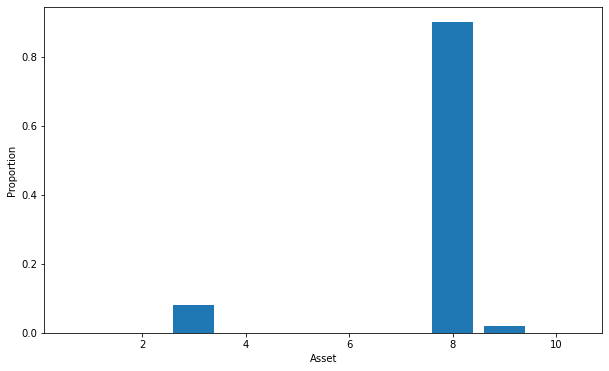

In [5]:
plt.figure(figsize = (10, 6))
plt.bar(x = np.arange(1, N + 1), height = x_star)
plt.xlabel("Asset")
plt.ylabel("Proportion")
plt.show()